In [1]:
from os import access
import pandas as pd
import numpy as np
import datetime
from pandas.core.reshape.concat import concat
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from datetime import date, datetime,timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
!pip install haversine
import haversine as hs

In [31]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping EmployeeData (HVC_AM0)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


#Reading the file and storing each line in the list text
with open ("C:/Users/HP/Desktop/Dev.Maarten/Python/Project/Data/HVC_AM0.csv", "r") as f:
    textEmployees = f.readlines()
textEmployees.pop(0)

#We make a dictionnary based on the data
CompanyEmployeesDict = {}

for e in textEmployees:
    Employee_ID, EmployeeNumber, Name, Postcode, Location, Language = e.replace("\n","").split(";")
    Employee_ID=int(Employee_ID)
    Postcode=int(Postcode)
    CompanyEmployeesDict[Employee_ID]= {"EmployeeNumber":EmployeeNumber,"Name": Name, "Postcode": Postcode, "Location": Location,"Language": Language }


#Some Employees do not have a EmployeeNumber: We set the EmployeeNumber of these employees to 0
#In this way we can convert all to a float
for e in CompanyEmployeesDict:
    E_ID = CompanyEmployeesDict[e]["EmployeeNumber"]
    if(E_ID == ""):
        CompanyEmployeesDict[e]["EmployeeNumber"]="0"
    CompanyEmployeesDict[e]["EmployeeNumber"] = int(float(CompanyEmployeesDict[e]["EmployeeNumber"]))   

df_CompanyEmployees = pd.DataFrame.from_dict(CompanyEmployeesDict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping ProductData (HVC_AR0)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("C:/Users/HP/Desktop/Dev.Maarten/Python/Project/Data/HVC_AR0.csv", "r") as f:
    textProducts = f.readlines()
textProducts.pop(0)

CompanyProductsDict = {}
for e in textProducts:
    ProductID, Description, Category, Family, Price = e.replace("\n","").split(";")
    ProductID = int(ProductID)
    CompanyProductsDict[ProductID]= {"Description":Description,"Category": Category, "Family": Family, "Price": Price}
   
#Some prices are missing   
for e in CompanyProductsDict:
  PriceCheck = CompanyProductsDict[e]["Price"]
  if(PriceCheck==""):
        CompanyProductsDict[e]["Price"]="0.0"
  CompanyProductsDict[e]["Price"]=float(CompanyProductsDict[e]["Price"])  

#Whenever they are Coupons they are not assigned a family
#We assign Coupon to its Family for clearity
for e in CompanyProductsDict:
  PriceCheck = CompanyProductsDict[e]["Family"]
  if(PriceCheck==""):
        CompanyProductsDict[e]["Family"]="Coupon"

df_Products = pd.DataFrame.from_dict(CompanyProductsDict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Reviews Data (HVC_CUSTOMER_REVIEWS)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------   


with open ("C:/Users/HP/Desktop/Dev.Maarten/Python/Project/Data/HVC_CUSTOMER_REVIEWS.csv", "r") as f:
    textCustReviews = f.readlines()
textCustReviews.pop(0)

CompanyReviewsDict = {}
for e in textCustReviews:
    CustomerID, Review  = e.replace("\n","").split(";")
    CustomerID = int(CustomerID)
    CompanyReviewsDict[CustomerID]= {"Review": Review}

df_Reviews = pd.DataFrame.from_dict(CompanyReviewsDict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Depot data (HVC_DEPOT)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


#Reading the file and storing each line in the list text
with open ("C:/Users/HP/Desktop/Dev.Maarten/Python/Project/Data/HVC_DEPOT.csv", "r") as f:
    text_Depot = f.readlines()
text_Depot.pop(0)

#We make a dictionnary based on the data
Depot_Dict = {}

for dep in text_Depot:
    Depot_Id, Depot_Location, Depot_Route = dep.replace("\n","").split(";")
    Depot_Id = int(Depot_Id)
    Depot_Route = int(Depot_Route)
    Depot_Dict[Depot_Id] = {"DEPOT":Depot_Location, "HVROUTETEMPLATE_NRID":Depot_Route}

#The Depot_Id and HVROUTETEMPLATE_NRID are both integers, Depot_Location
#The names of the keys are based on the table descriptions for easy looking up in case of further calculations
#There are no missing values in our dictionnary so further preprocessing is not necessary.

df_Depot = pd.DataFrame.from_dict(Depot_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping DaysOfWeek (HVC_HVDAYOFWEEK)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("C:/Users/HP/Desktop/Dev.Maarten/Python/Project/Data/HVC_HVDAYOFWEEK.csv", "r") as f:
    text_DayOfWeek = f.readlines()
text_DayOfWeek.pop(0)

#We make a dictionnary based on the data
DayOfWeek_Dict = {}

for day in text_DayOfWeek:
    HVDAYOFWEEK_NRID, DAY = day.replace("\n","").split(";")
    HVDAYOFWEEK_NRID = int(float(HVDAYOFWEEK_NRID))
    DayOfWeek_Dict[int(HVDAYOFWEEK_NRID)] = DAY


#The HVDAYOFWEEK_NRID is an integer, DAY is a string. 
#!! important notice for further caclulations, the first day (day with id = 1) is a sunday! Not a monday!
df_DaysOfWeek = pd.DataFrame.from_dict(DayOfWeek_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Position data (HVC_HVPOSITION)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("C:/Users/HP/Desktop/Dev.Maarten/Python/Project/Data/HVC_HVPOSITION.csv", "r") as f:
    text_Position = f.readlines()
text_Position.pop(0)

#We make a dictionnary based on the data
Position_Dict = {}

for loc in text_Position:
    SO0_NRID, LONG, LAT = loc.replace("\n","").split(";")
    SO0_NRID = int(float(SO0_NRID))
    LONG = float(LONG)
    LAT = float(LAT)
    Position_Dict[SO0_NRID] = {"LONG":LONG, "LAT":LAT}

#SO0_NRID is int, LONG and LAT are both float values.

df_Position = pd.DataFrame.from_dict(Position_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Route Template data (HVC_HVROUTETEMPLATE)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("C:/Users/HP/Desktop/Dev.Maarten/Python/Project/Data/HVC_HVROUTETEMPLATE.csv", "r") as f:
    textRouteTemplate = f.readlines()
    textRouteTemplate.pop(0)
    
RouteTemplate_Dict = {}

for route in textRouteTemplate:
    HVROUTETEMPLATE_NRID, REGION, WEEKORDER, HVDAYOFWEEK_NRID = route.replace("\n","").split(";")
    HVROUTETEMPLATE_NRID=int(float(HVROUTETEMPLATE_NRID))
    RouteTemplate_Dict[HVROUTETEMPLATE_NRID] = {"REGION": REGION, "WEEKORDER": WEEKORDER, "DAYOFWEEK_NRID": HVDAYOFWEEK_NRID}        

df_RouteTemplate = pd.DataFrame.from_dict(RouteTemplate_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping Visit Outcome data (HVC_HVVISITOUTCOME)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("C:/Users/HP/Desktop/Dev.Maarten/Python/Project/Data/HVC_HVVISITOUTCOME.csv", "r") as f:
    textVisitOutcome = list()
    for line in f:
        line = line.replace("\n","")
        obs = line.split(";")
        textVisitOutcome.append(obs)

column_names = textVisitOutcome[0]
textVisitOutcome.pop(0)
VisitOucome_Dict = {}

for visit in textVisitOutcome:
    VisitOucome_Dict[visit[1]] = visit[0]


df_VisitOutcome = pd.DataFrame.from_dict(VisitOucome_Dict, orient = 'index')


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping TransactionData (HVC_HVVISITRESULT)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


#Reading the file and storing each line in the list text
with open ("C:/Users/HP/Desktop/Dev.Maarten/Python/Project/Data/HVC_HVVISITRESULT.csv", "r") as f:
    textVisit = f.readlines()
textVisit.pop(0)

#We make a dictionnary based on the data
CompanyVisitDict = {}

for e in textVisit:
    Visit_ID, Customer_ID, Employee_ID, VisitOutcome_ID, Time, Date, Amount, paymentMethod = e.replace("\n","").split(";")
    Visit_ID= int(Visit_ID)

    yYear, mMonth, dDay = Date.split("-")
    yYear = int(yYear)
    mMonth = int(mMonth)
    dDay = int(dDay)
    Date=date(yYear,mMonth,dDay)

    Customer_ID= int(Customer_ID)
    Employee_ID= int(Employee_ID)
    VisitOutcome_ID= int(VisitOutcome_ID)
    Amount= float(Amount)
    CompanyVisitDict[Visit_ID]= {"Customer_ID":Customer_ID,"Employee_ID": Employee_ID, "VisitOutcome_ID": VisitOutcome_ID, "Time": Time,"Date": Date, "Amount": Amount, "paymentMethod": paymentMethod }

#Some visits do not have a payment method recorded: We set the paymentMethod of these cases to the None variable
#Maybe these missing values will have value later on
for e in CompanyVisitDict:
    P_method = CompanyVisitDict[e]["paymentMethod"]
    if(P_method == ""):
        CompanyVisitDict[e]["paymentMethod"]= None

df_CompanyVisit = pd.DataFrame.from_dict(CompanyVisitDict, orient = 'index')

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping EmployeeData (HVC_SO0)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


#Reading the file and storing each line in the list text
with open ("C:/Users/HP/Desktop/Dev.Maarten/Python/Project/Data/HVC_SO0.csv", "r") as f:
    textCustomerType = f.readlines()
textCustomerType.pop(0)

#We make a dictionnary based on the data
CustomerTypeDict = {}

for e in textCustomerType:
    Customer_ID, RouteTemplate_ID, CustomerType, Postcode, Language, Season = e.replace("\n","").split(";")
    Customer_ID=int(float(Customer_ID))
    RouteTemplate_ID=int(float(RouteTemplate_ID))
    Postcode = int(float(Postcode))
    CustomerTypeDict[Customer_ID]= {"RouteTemplate_ID":RouteTemplate_ID,"CustomerType": CustomerType, "Postcode": Postcode, "Language": Language,"Season": Season}


df_CustomerType = pd.DataFrame.from_dict(CustomerTypeDict, orient = 'index')

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Prepping ProductData (HVC_VISITRESULTDETAILS)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


with open ("C:/Users/HP/Desktop/Dev.Maarten/Python/Project/Data/HVC_VISITRESULTDETAILS.csv", "r") as f:
    textVisitDetails = f.readlines()
textVisitDetails.pop(0)


#We make a dictionnary based on the data
VisitDetailsDict = {}


for e in textVisitDetails:
    VisitDetails_ID, Product_ID, Quantity, Visit_ID = e.replace("\n","").split(";")
    VisitDetails_ID=int(VisitDetails_ID)
    Product_ID=int(Product_ID)
    Quantity=int(float(Quantity))
    Visit_ID=int(float(Visit_ID))
    VisitDetailsDict[VisitDetails_ID]= {"Product_ID":Product_ID,"Quantity": Quantity, "Visit_ID": Visit_ID}

df_VisitDetails = pd.DataFrame.from_dict(VisitDetailsDict, orient = 'index')

#We add a a selfmade database of average and median household income per postal code, the document is called Income_per_postcode2.csv
df_Income_per_postcode = pd.read_csv("C:/Users/HP/Desktop/Dev.Maarten/Python/Project/Data/Income_per_postcode2.csv")
#This dataframe may be important for several regressions questions 


#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#This gives us the following 11 dataframes to work with:
# 1  df_CompanyEmployees (HVC_AM0)
# 2  df_Products (HVC_AR0)
# 3  df_Reviews  (HVC_CUSTOMER_REVIEWS)
# 4  df_Depot  (HVC_DEPOT)
# 5  df_DaysOfWeek (HVC_HVDAYOFWEEK)
# 6  df_Position (HVC_HVPOSiTION)
# 7  df_RouteTemplate (HVC_HVROUTETEMPLATE)
# 8  df_VisitOutcome (HVC_HVVISITOUTCOME)
# 9  df_CompanyVisit (HVC_VISITRESULT)
# 10 df_CustomerType (HVC_SO0)
# 11 df_VisitDetails (HVC_VISITRESULTDETAILS)
# 12 df_Income_per_postcode (Income_per_postcode2, data source link: https://statbel.fgov.be/nl/themas/huishoudens/fiscale-inkomens#panel-13 )",
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
###########################
#Q1: What are the Products?
###########################

In [3]:
#Q1.1 What are the most frequently bought products?
#Firstly we construct a new dataframe Aureum: in this dataframe
#We sum all quantities over it's unique product_ID
#in this way we get the total amount a certain product/product_ID is bought
#over all visits
Aureum = df_VisitDetails.groupby("Product_ID")["Quantity"].sum()
#Next we merge this dataframe with df_products so we can get the description
#Family and all other information on every single Product_ID
#This is a left merge since some Products might not have been bought during visits
#And in this way we can prevent NAN
newAU = pd.merge(Aureum, df_Products, how="left", on=Aureum.keys())
#We make a new Column Revenue: This is the price of a product multiplied by the 
#Quantity the product has sold for: giving us the complete revenue of a specified product
#This is used in later questions
Revenue = newAU["Price"]*newAU["Quantity"]
#We add this column to the newAu dataframe
newAU["RevenueProduct"] = Revenue


#In order to get the most sold products: we sort on Quantity giving the most sold
#products with their description on top
#The anwser to this question can be found by printing the head of this dataframe
#Worst products can be found by looking at the tail
BestAmountSoldProducts = newAU.sort_values(by="Quantity", ascending=False)

#print(BestAmountSoldProducts.head(5))

In [4]:
#Q1.2 Which products render the most revenue?
#For this we use the added revenue column on newAU from Question 1.1
#By sorting on this column and putting ascending to False
#We get the products with their description with the best revenue on top
#The anwser can be found by printing the head of this dataframe
BestRevProducts = newAU.sort_values(by="RevenueProduct", ascending=False)

#print(BestRevProducts.head(5))

In [5]:
#Q1.3 Which products are bought the most in the region of Brussels, Antwerp, …?
# merge routetemplate and depot to see if the region code and depot location are connected
# first we define the keys of the Route Template dataframe as an extra column so they can be accessed
# then we give the keys of the depot an appropriate name in order to merge them with more convenience
df_RouteTemplate["RouteTemplate_ID"] = df_RouteTemplate.index
df_Depot["RouteTemplate_ID"] = df_Depot["HVROUTETEMPLATE_NRID"]
RouteTemplate_with_DepotLocation = pd.merge(df_RouteTemplate, df_Depot, how = "inner", on = "RouteTemplate_ID")
RouteTemplate_with_DepotLocation.head(5)

# out of the previous dataframe it becomes clear that the location of the depot and the region code are not always 
# the same for each location
# now we are going to create a dataframe in which the quantity of the products sold and the location of the depot
# are both present, therefore we have to merge multiple dataframes
Customer_with_DepotLocation = pd.merge(df_CustomerType, RouteTemplate_with_DepotLocation, how = "inner", on = "RouteTemplate_ID")
Customer_with_DepotLocation

# To merge the following dataframes, we first need to create an extra column with the customer ID's 
# for the CustomerType so they can be accessed in the future, the same goes for the Visit_ID of CompanyVisit
# and the product_ID of products
df_CustomerType["Customer_ID"] = df_CustomerType.index
df_CompanyVisit["Visit_ID"] = df_CompanyVisit.index
df_Products["Product_ID"] = df_Products.index

# merge the Customer_with_DepotLocation dataframe with the results of the visit (= dataframe CompanyVisit)
Visit_with_DepotLocation = pd.merge(Customer_with_DepotLocation, df_CompanyVisit, how = "inner", on = "Customer_ID")
Visit_with_DepotLocation

# now we are going to merge this dataframe, with the VisitDetails dataframe in order to gain information about the
# product_ID's and the quantities sold
Quantity_with_DepotLocation = pd.merge(Visit_with_DepotLocation, df_VisitDetails, how = "inner", on = "Visit_ID")
Quantity_with_DepotLocation

# here we already are going to look in which depots the most quantities are sold
Quantity_with_DepotLocation.groupby("DEPOT")["Quantity"].sum()

# Now we are going to look which products are most sold in which region?
# with the location of the depots I worked as followed:
# 1) first I merged the previous dataframe Quantity_with_DepotLocation with df_Products on product_ID in order to
# get more information about the product and its description
# 2) then i created 4 subsamples (= the four locations of the depots)
# 3) i looked in every dataframe which product was sold how many times by grouping the dataframe by 
# its product_ID and taking the sum of the quantities and stored this data per location/sub_dataframe
# 4) Next we merge this dataframe with df_products so we can get the description
# Family and all other information on every single Product_ID

# 1) 
Products_with_DepotLocation_1 = pd.merge(Quantity_with_DepotLocation, df_Products, how = "inner", on = "Product_ID")
Products_with_DepotLocation_1

# 2)# make a subselection of the dataframe based on the location of the depot
df_Deinze = Products_with_DepotLocation_1[Products_with_DepotLocation_1["DEPOT"] == "Deinze"]
df_Aarschot = Products_with_DepotLocation_1[Products_with_DepotLocation_1["DEPOT"] == "Aarschot"]
df_Antwerpen = Products_with_DepotLocation_1[Products_with_DepotLocation_1["DEPOT"] == "Antwerpen"]
df_Vilvoorde = Products_with_DepotLocation_1[Products_with_DepotLocation_1["DEPOT"] == "Vilvoorde"]

# 3 + 4) 

product_quantities_Deinze = df_Deinze.groupby("Product_ID")["Quantity"].sum()
df_Products_Deinze = pd.merge(product_quantities_Deinze, df_Products, how = "inner", on = "Product_ID")
#print(df_Products_Deinze.sort_values(by = "Quantity", ascending = False).head(10))

product_quantities_Aarschot = df_Aarschot.groupby("Product_ID")["Quantity"].sum()
df_Products_Aarschot = pd.merge(product_quantities_Aarschot, df_Products, how = "inner", on = "Product_ID")
#print(df_Products_Aarschot.sort_values(by = "Quantity", ascending = False))

product_quantities_Antwerpen = df_Antwerpen.groupby("Product_ID")["Quantity"].sum()
df_Products_Antwerpen = pd.merge(product_quantities_Antwerpen, df_Products, how = "inner", on = "Product_ID")
#print(df_Products_Antwerpen.sort_values(by = "Quantity", ascending = False))

product_quantities_Vilvoorde = df_Vilvoorde.groupby("Product_ID")["Quantity"].sum()
df_Products_Vilvoorde = pd.merge(product_quantities_Vilvoorde, df_Products, how = "inner", on = "Product_ID")
#print(df_Products_Vilvoorde.sort_values(by = "Quantity", ascending = False))


KeyError: 'Customer_ID'

In [ ]:
#Q1.4 Are product purchases correlated? Are some products often purchased together?

In [6]:
#Q1.5 What are the total sales generated for each product family?
#Using the earlier dataframes based on quantity and revenue we can anwser these questions
#By simply grouping over each Family or Catogory and then taking the sum of either Revenue or Quanitity
#And then sorting the values to get the largest on top
#This way if we group on a family and then sum each revenue from all products for that family for example
#We can anwser the question 

#Based on Family
#Generated Revenue
BestRevFamily=BestRevProducts.groupby("Family")["RevenueProduct"].sum().sort_values(ascending=False)
#Based on Family
#Amount sold
BestAmountFamily=BestAmountSoldProducts.groupby("Family")["Quantity"].sum().sort_values(ascending=False)

#Based on Catogery
#Generated Revenue
BestRevCat=BestRevProducts.groupby("Category")["RevenueProduct"].sum().sort_values(ascending=False)

#Based on Catogery
#Amount sold
BestAmountCat=BestRevProducts.groupby("Category")["Quantity"].sum().sort_values(ascending=False)

#The anwser can be found by printing all the dataframes
#The dataframes are not big so no need to use head

#print(BestRevFamily)
#print(BestRevCat)

In [7]:
#Q1.6 Does the weather / seasonal changes have an effect on the total revenue?
#IMPORTANT This question requires the dataFrame newAU from 1.1

#This is used to define a function that calculates which season a given date is
#This function: 'get_season' returns the season of a date
Y=2020
seasons = [('Winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('Spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('Summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('Autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('Winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

#We then apply this function on the column Date to get the Seasons
#We store the correspondent season on a new column in the dataframe: "Season"

df_CompanyVisit["Season"]=df_CompanyVisit["Date"].apply(get_season)
#By grouping on Season and taking the sum of Amounts for each season we can anwser the question
df_Seasonality=df_CompanyVisit.groupby("Season")["Amount"].sum()
#Use percentages
df_Seasonality=(df_Seasonality/df_Seasonality.values.sum())*100

print(df_Seasonality.head(5))

Season
Autumn    23.119592
Spring    29.363978
Summer    29.239115
Winter    18.277316
Name: Amount, dtype: float64


In [ ]:
##########################
#Q2 Who are the customers?
##########################

In [8]:
#Q2.1 What do customers buy?
#We decided to skip this question
#We already anwser which are the most sold products and in which seasons, which category in
#Q1. So this is already kind of what customers buy
#In later Questions in Q2 we go deeper on who the customers are: We define churners, Clusters
#buying patterns etc so this questions seemed ambigious and non-specific to us
#For an anwser we refer to the Questions from Q1 and Q2

In [9]:
#Q2.2 Which customers left the company?
#We define churn as not having bought from the company for a complete year
#We decided upon this because a whole year encompasses all seasons so
#this way we can incorprates seasonality: some might only buy in a specific season
#and we don't want to eliminate these customers

#First get the customers and their dates they visited
df_CustomersWithDates = df_CompanyVisit[["Customer_ID","Date"]]

#Get the most recent date over the whole dataframe
#This is the snapshot date of the database
mostRecent= max(df_CompanyVisit["Date"])
daysinaYear = 365

#We define the chruncap as the mostRecent date in the database
#-365 days: a year: this is considerd churn if >
ChurnCap = mostRecent - timedelta(daysinaYear)

#We calculate the last time a customer has visited
df_CustomersWithDates["LastVisit"] = mostRecent - df_CustomersWithDates["Date"]


#Here needs to come a function that loops over each unique customer ID
#Gets all its dates: only keeps the most recent date
#We do this by sorting the pandaframe on Date
#Now all dates are ordered to the most recent on top
#In this way we can drop duplicate Customer_ID
#Since the drop function keeps the most top Customer_ID: so when 
#Dates are ordered the Customer_ID is kept with it's most recent visit Date

df_CustomersWithDates["Date"] = pd.to_datetime(df_CustomersWithDates["Date"])
df_CustomersWithDates = df_CustomersWithDates.sort_values(by="Date", ascending=False)
df_CustomersWithDates = df_CustomersWithDates.drop_duplicates(subset=['Customer_ID'])

#So now we calculate if the most recent visit of an unique CustomerID has been longer 
#Than 365 days so wheter or not they have churned
def isOk(ditt: datetime.date):
    if((ditt >= ChurnCap)):
        return "no"
    else:
        return "yes"

df_CustomersWithDates["Churn?"]=df_CustomersWithDates["Date"].apply(isOk)   

#We split churned customers and non churners into seperate dataframes
df_ChurnedCustomers= df_CustomersWithDates[df_CustomersWithDates["Churn?"] == "yes"]
df_nonChurnedCustomers = df_CustomersWithDates[df_CustomersWithDates["Churn?"] == "no"]
       
#Now we can provide a dataframe containing all by us defined churned customers       
#print(df_ChurnedCustomers.head(5))
#print(df_nonChurnedCustomers.head(5))

#We have 152 churned customers and 5460 non churned customers
#In total we have 5709 customers: so some do not have purchases

#print(len(df_CustomerType["Customer_ID"].unique()))
#print(len(df_ChurnedCustomers))
#print(len(df_nonChurnedCustomers))

<ipython-input-9-1d128efcdd8e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CustomersWithDates["LastVisit"] = mostRecent - df_CustomersWithDates["Date"]
<ipython-input-9-1d128efcdd8e>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CustomersWithDates["Date"] = pd.to_datetime(df_CustomersWithDates["Date"])


In [10]:
#Q2.3 Which customers have the highest CLV?
#First we only select the visits which are succesfull and have a transaction
#This being VisitOutcome_ID =2
df_OnlySuccesFullVisits= df_CompanyVisit[df_CompanyVisit["VisitOutcome_ID"] == 2]
df_OnlySuccesFullVisits= df_OnlySuccesFullVisits.sort_values("Customer_ID")
#We sum the amounts of money spent per Customer_ID over it's lifetime and this gives the CLV of all Customers in descending order
df_CLV=df_OnlySuccesFullVisits.groupby("Customer_ID")["Amount"].sum().sort_values(ascending=False)

#By printing the head of this new dataframe we can see the customers with the highest CLV on top
#print(df_CLV.head(50))

In [14]:
#Q2.4 What is the relationship between leaving the company and buying patterns?

##########################################################################################
#IMPORTANT To run this however you need to run Q2.6 first!!! (There we calculate DateINDEX)
###RUN Q2.6 FIRST!!!!!!!!!!!!!!!!!
# IMPORTANT !!!!!!!!!!!!!!!!!!!!!!!!
##########################################################################################

#Firstly we drop unnessary columns from Company visit for this analysis
df_ChurnedBuyingPatterns = df_CompanyVisit.drop(columns=["Time","VisitOutcome_ID","Employee_ID","paymentMethod","Date"])

#We merge this dataframe with visitdetails so we can get the product ID's bought on specific Visit_ID's
df_ChurnedBuyingPatternsIn = pd.merge(df_ChurnedBuyingPatterns, df_VisitDetails, how="left",on="Visit_ID")
#We drop NAN rows and drop unnesccary columns like churn and lastvisit: we also do not need the Visit_ID anymore
df_ChurnedBuyingPatterns = pd.merge(df_ChurnedCustomers,df_ChurnedBuyingPatternsIn, how="left",on="Customer_ID").dropna().drop(columns=["Churn?","LastVisit","Date","Visit_ID"])
df_nonChurnedBuyingPatterns = pd.merge(df_nonChurnedCustomers,df_ChurnedBuyingPatternsIn, how="left",on="Customer_ID").dropna().drop(columns=["Churn?","LastVisit","Date","Visit_ID"])
#We now have a dataframe with customers the amount that they spent in which season and which dateINDEX

#We now look at the amount spent of these churned customers over Season and dateIndex: being weekend or weekday
#We can accomplish this by grouping over these factors and summing the amount they have spent
#We want take averages so define the following
Churnies = len(df_ChurnedCustomers)
nonChurnies = len(df_nonChurnedCustomers)

#This dataframe describes seasonality of churned customers
df_ChurnedSeasonality= df_ChurnedBuyingPatterns.groupby("Season")["Amount"].sum()/Churnies
df_nonChurnedSeasonality= df_nonChurnedBuyingPatterns.groupby("Season")["Amount"].sum()/nonChurnies
#We take percentage distribution 
df_ChurnedSeasonality = (df_ChurnedSeasonality/df_ChurnedSeasonality.values.sum())*100
df_nonChurnedSeasonality= (df_nonChurnedSeasonality/df_nonChurnedSeasonality.values.sum())*100
#This dataframe describes the influence of Weekday/Weekkend
df_ChurnedWeeklyWeekend = df_ChurnedBuyingPatterns.groupby("DateIndex")["Amount"].sum()/Churnies
df_nonChurnedWeeklyWeekend = df_nonChurnedBuyingPatterns.groupby("DateIndex")["Amount"].sum()/nonChurnies

df_ChurnedWeeklyWeekend=df_ChurnedWeeklyWeekend/df_ChurnedWeeklyWeekend.values.sum()
df_nonChurnedWeeklyWeekend=df_nonChurnedWeeklyWeekend/df_nonChurnedWeeklyWeekend.values.sum()

#In order to identify revenue from Family, Catogory and unique products
#We need to merge this dataframe with df_products on product ID to get the info on the bought products
#this is a left merge to prevent NAN
df_ChurnedProducts = pd.merge(df_ChurnedBuyingPatterns,df_Products, how="left",on="Product_ID")
df_nonChurnedProducts = pd.merge(df_nonChurnedBuyingPatterns,df_Products, how="left",on="Product_ID")

#We can now do the same analytics as for seasonality
#Family
df_ChurnedFamilyRev = df_ChurnedProducts.groupby("Family")["Amount"].sum()/Churnies
df_nonChurnedFamilyRev = df_nonChurnedProducts.groupby("Family")["Amount"].sum()/nonChurnies

df_ChurnedFamilyRev = (df_ChurnedFamilyRev/df_ChurnedFamilyRev.values.sum())*100
df_nonChurnedFamilyRev = (df_nonChurnedFamilyRev/df_nonChurnedFamilyRev.values.sum())*100

#Cat
df_ChurnedCatRev = df_ChurnedProducts.groupby("Category")["Amount"].sum()/Churnies
df_nonChurnedCatRev = df_nonChurnedProducts.groupby("Category")["Amount"].sum()/nonChurnies

df_ChurnedCatRev = (df_ChurnedCatRev/df_ChurnedCatRev.values.sum())*100
df_nonChurnedCatRev = (df_nonChurnedCatRev/df_nonChurnedCatRev.values.sum())*100

#Desc
df_ChurnedProdRev = df_ChurnedProducts.groupby("Description")["Amount"].sum()/Churnies
df_nonChurnedProdRev = df_nonChurnedProducts.groupby("Description")["Amount"].sum()/nonChurnies

df_ChurnedProdRev=(df_ChurnedProdRev/df_ChurnedProdRev.values.sum())*100
df_nonChurnedProdRev =(df_nonChurnedProdRev/df_nonChurnedProdRev.values.sum())*100

#Insights for this question can be found by comparing the dataframes from churners with nonchurners

#X are churners Y are nonchurners
df_comparisonSeas = pd.merge(df_ChurnedSeasonality,df_nonChurnedSeasonality, on="Season")
#df_comparisonSeas["Season"] = df_comparisonSeas["Season"]/df_comparisonSeas["Season"].sum()
df_comparisonWeek = pd.merge(df_ChurnedWeeklyWeekend,df_nonChurnedWeeklyWeekend, on="DateIndex")

df_comparisonFam = pd.merge(df_ChurnedFamilyRev,df_nonChurnedFamilyRev, on="Family")
df_comparisonCat = pd.merge(df_ChurnedCatRev,df_nonChurnedCatRev, on="Category")
df_comparisonDesc = pd.merge(df_ChurnedProdRev,df_nonChurnedProdRev, on="Description")

#print(df_comparisonSeas) #Churnes buy alot more in Spring, a little bit in summer but close to nothing in Autumn and Winter
#print(df_comparisonWeek) #no conclusion

#print(df_comparisonFam) #Churners buy twice as much coffee, do not use coupons, order more cups and garniture
#print(df_comparisonCat) #No conclusion
#print(df_comparisonDesc) #No conclusion

#------------------------------------------------------------------------------#
####IMPORTANT Q2.3 MUST BE SOLVED FIRST####

#As we try to find a relationship (a regression (logistic)) between the churning of a customer and their purchase behavior
#we must start by initializing our data. 

#As our dependent variable we chose the variable Churn as stated previously in question 2.3
#in the dataframe df_CustomerWithDates we have the relevant information, but also less relevant information 
#such as Date and LastVisit so we will drop those columns. Next we will transform the Churn? label into a binary variable. 

df_churner0 = df_CustomersWithDates.drop(columns = ["Date", "LastVisit"])
#This is the df_CustomerWithDates but only containing customer ID and whether or not this customer churns

#now we initialize the LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df_churner0["Churn?"])
df_churner0["Churn_binary"] = label_encoder.transform(df_churner0["Churn?"])
df_churner1 = df_churner0.drop(columns = ["Churn?"])

# df_churner1 is the new dataframe containg customer_id and a 0 if they did not churn, a 1 if they did. 
#print(df_churner1)

#next we will try te derive some (possible) important variables.
# 1) average number of purchases per customer
# 2) average amount spent per purchase per customer
# 3) average spending per month per customer
# 4) average time between purchases per customer

#MAYBE
# 5) purchase in the weekend or not/purchasing on a certain day in the week


In [17]:
#We merge these two dataframes below, if an error occurs you must add a copy of the Visit_ID column 
#to the dataframe so we can merge.
#run this code before: 
df_CompanyVisit["Visit_ID"] = df_CompanyVisit.index
total = pd.merge(df_CompanyVisit, df_VisitDetails, how = "left", on = "Visit_ID")
#Since we are looking at the buyer pattern we only look at the visits that were succesfull (value = 2) 
#(e.g. where something was bought)
total = total[total.VisitOutcome_ID.isin([0,1]) == False]

#total



#Most of the variables that we are going to calculate will be average values (for simplicity)
#As the total timespan for averaging over time I will take the timespan between the first and last purchase
df_new = df_CompanyVisit.groupby("Customer_ID")["Date"].max()
df_old = df_CompanyVisit.groupby("Customer_ID")["Date"].min()
timespan = df_new - df_old


#then, due to the nature of the timespan variable being a time.delta (we can't perform mathematical actions with this var)
#I will convert this variable to an integer. The number of days will be converted to a number of months, this is done via 
#a transformation to a string value and then to an integer value of the days, then the days are divided by 30 for the number
#of months.
lijst = []
for i in timespan:
    text = str(i)
    num, day, time = text.split(" ")
    if int(num) != 0:
        lijst.append(int(num)/30)
    else:
        lijst.append(1)
    
#and we add these information to our churndataframe    
df_churner1["atl_maanden"] = lijst

#df_churner1

In [18]:
# 1) number of average purchases per customer

#first we create a dataframe that tells us the number of succesfull purchases per customer.
df_num_purchases = pd.DataFrame(total.groupby("Customer_ID")["Visit_ID"].nunique())
df_num_purchases.columns = ["num_purchases"]

#We merge our newfound dataframe to our previous churning dataframe, all NA values are filled in by a 0. 
df_churner2 = pd.merge(df_churner1, df_num_purchases, how = "left", on = "Customer_ID")
df_churner2["num_purchases"] = df_churner2["num_purchases"].fillna(0)

#the average number of purchases per month are found by dividing the total number of purchases by the number of months
#in the timespan of the customer
df_churner2["av_num_purch_month"] = df_churner2["num_purchases"]/df_churner2["atl_maanden"]

#df_churner2

In [19]:
#2) Average amount spent per purchase
amount = total.groupby("Customer_ID")["Amount"].sum() #total amount spent per customer.

df_churner3 = pd.merge(df_churner2, amount, how = "left", on = "Customer_ID")
df_churner3["Amount"] = df_churner3["Amount"].fillna(0) #we fillin all the NA values with a 0. 

#The average amount spent per purchase is added to the dataframe, all NA values are filled with a 0.
df_churner3["av_amount_spent_per_purchase"] = (df_churner3["Amount"]/df_churner3["num_purchases"]).fillna(0)

In [20]:
#3) average spending per month per customer
df_churner3["av_spending_per_month"] = df_churner3["Amount"]/df_churner3["atl_maanden"]

In [21]:
#4) average time between purchases per customer

#we create a for loop where we itereate over the unique customer_ID. For each customer ID we will look at all the datetime values
#present. We sort the date times for each customer_ID from most recent to least recent, this block of info of all dates
#per customer_ID is called the subset. 
#In this subset we iterate over all dates and we take the difference between two consecutive dates to measure the timespan between
#the purchases. If the timespan equals 0 that means that there were multiple products/deliviries on that date so we can omit those
#values via the if statement. 
#finally we transoform our date time argument to an int via the int(diff.days) fucntion and save everything in a dictionairy
boekje = dict() 
for cust in total["Customer_ID"].unique(): 
    subset = total[total["Customer_ID"]== cust].sort_values(by = "Date", ascending = False)
    l = []
    for i in range(0, len(subset.index)-1): 
        diff = subset.iloc[i, 4] - subset.iloc[i+1,4]                   #IMPORTANT!!!!!!! The Date column in the total
        if int(diff.days) > 0:                                          #dataframe is the 5the column (so 4th index). 
            l.append(int(diff.days))                                    #suppose there is an error, double check if the fifth
        else:                                                           #column is still Date, otherwise change it
            continue 
    try:
        gem = st.mean(l)
    except:
        gem = None
    boekje[cust] = gem

#We transform our dictionairy to a dataframe
df_av_time_between_purchases = pd.DataFrame.from_dict(boekje, orient = 'index')

#we give a name to our first column and we add a duplicate of our CUSTOMER_ID so that we can merge in the next step
df_av_time_between_purchases.columns = ["Av_num_days_between_purchases"]
df_av_time_between_purchases["Customer_ID"] = df_av_time_between_purchases.index

#merge the dataframes to get churner4
df_churner4 = pd.merge(df_churner3, df_av_time_between_purchases, how = "left", on = "Customer_ID")
df_churner4["Av_num_days_between_purchases"] = df_churner4["Av_num_days_between_purchases"].fillna(730)
#For all the customers that have a 0 for time between purchases we give a value of 730 days, this means that they didnt buy
#anything during the two years that the dataset exists.

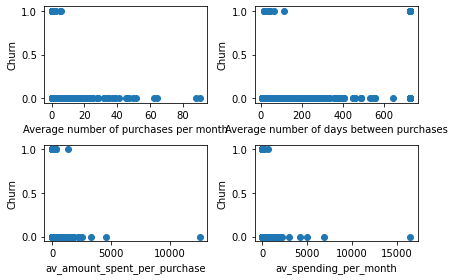

In [22]:
#so as we start with our logistic regression we have the following:
#dependent variable = Churn_binary

#independent variable =
# -av_num_purch_month 
# -Av_num_days_between_purchases
# -av_amount_spent_per_purchase
# -av_spending_per_month

lr_model1 = LogisticRegression()
lr_model2 = LogisticRegression()
lr_model3 = LogisticRegression()
lr_model4 = LogisticRegression()


lr_model1.fit(df_churner4[["av_num_purch_month"]], df_churner4["Churn_binary"])
lr_model2.fit(df_churner4[["Av_num_days_between_purchases"]], df_churner4["Churn_binary"])
lr_model3.fit(df_churner4[["av_amount_spent_per_purchase"]], df_churner4["Churn_binary"])
lr_model4.fit(df_churner4[["av_spending_per_month"]], df_churner4["Churn_binary"])

churn_est1 = lr_model1.predict(df_churner4[["av_num_purch_month"]])
churn_est2 = lr_model1.predict(df_churner4[["Av_num_days_between_purchases"]])
churn_est3 = lr_model1.predict(df_churner4[["av_amount_spent_per_purchase"]])
churn_est4 = lr_model1.predict(df_churner4[["av_spending_per_month"]])


plt.subplot(2,2,1)
plt.scatter(df_churner4["av_num_purch_month"], df_churner4["Churn_binary"])
plt.xlabel("Average number of purchases per month")
plt.ylabel("Churn")

plt.subplot(2,2,2)
plt.scatter(df_churner4["Av_num_days_between_purchases"], df_churner4["Churn_binary"])
plt.xlabel("Average number of days between purchases")
plt.ylabel("Churn")

plt.subplot(2,2,3)
plt.scatter(df_churner4["av_amount_spent_per_purchase"], df_churner4["Churn_binary"])
plt.xlabel("av_amount_spent_per_purchase")
plt.ylabel("Churn")


plt.subplot(2,2,4)
plt.scatter(df_churner4["av_spending_per_month"][df_churner4["av_spending_per_month"] < 20000], df_churner4["Churn_binary"][df_churner4["av_spending_per_month"] < 20000])
plt.xlabel("av_spending_per_month")
plt.ylabel("Churn")

plt.tight_layout()


#Our predictions for these variables are not really that significant so maybe some other variables should be looked at,
#maybe our churn should change?

In [ ]:
#the confusion matrix is rather useless because we 'predict' that almost every customer won't churn according to our definition
#sklearn.metrics.confusion_matrix(df_churner4["Churn_binary"] , churn_est1)
#sklearn.metrics.confusion_matrix(df_churner4["Churn_binary"] , churn_est2)
#sklearn.metrics.confusion_matrix(df_churner4["Churn_binary"] , churn_est3)
#sklearn.metrics.confusion_matrix(df_churner4["Churn_binary"] , churn_est4)

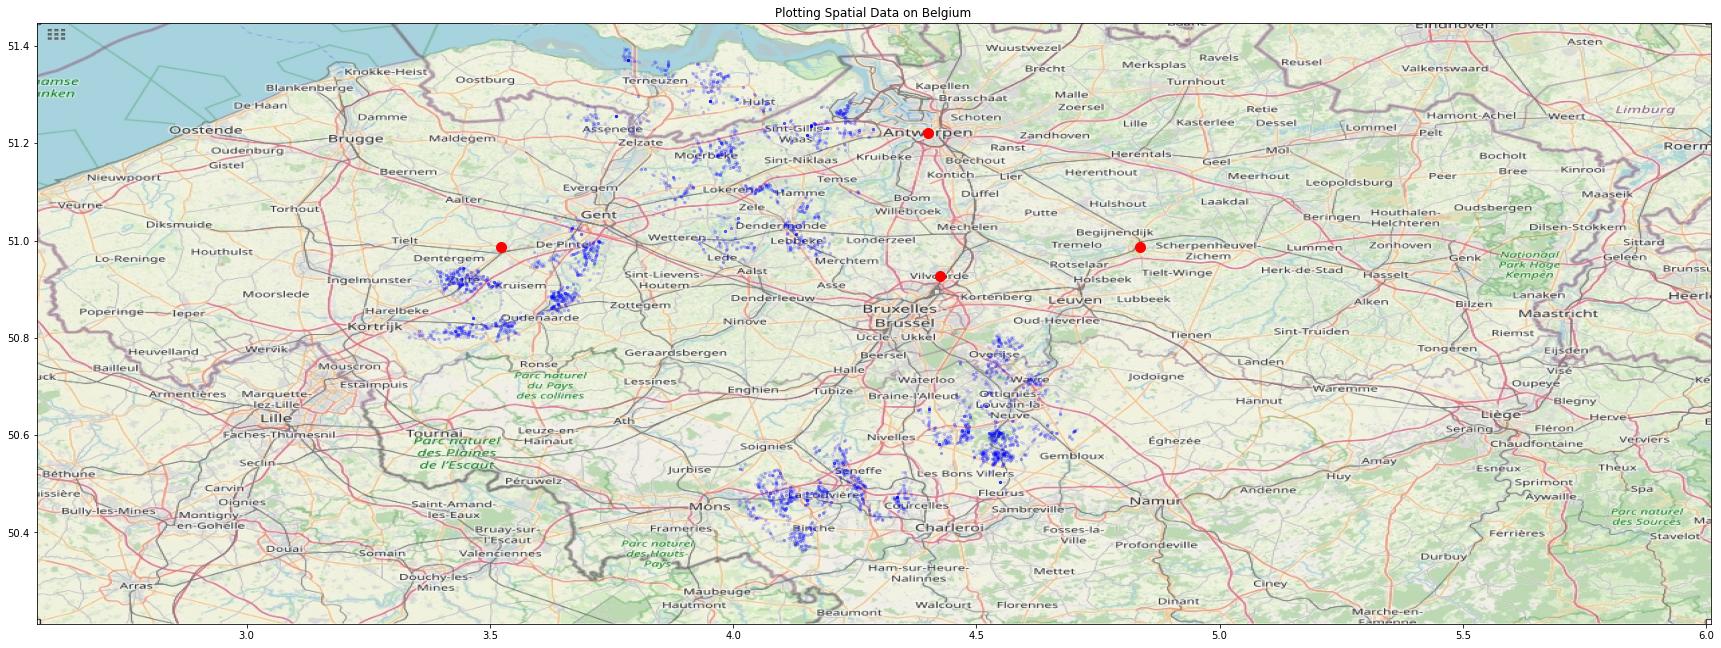

In [23]:
#Q2.5 Are there clusters of customers? How would you describe these different clusters?
###########################################################################################################################
#IMPORTANT To run this however you need to run Q2.7 first!!! We need CLV column from Customertype and this is added in Q2.7
# IMPORTANT !!!!!!!!!!!!!!!!!!!! 
######################################################################################################################


#Q2.5 Are there clusters of customers? How would you describe these different clusters?

#let's start by looking at the maximum range of the coordinates, we create a Bounding Box
BBox = ((df_Position["LONG"].min(), df_Position["LONG"].max(), df_Position["LAT"].min(), df_Position["LAT"].max()))
#the min and max LONG and LAT are respectively: (3.334474113603079, 4.707188589012247, 49.62586258530627, 51.39655183995949)

#Next we load a screenshot of belgium, this screenshot was taken on the website: 
#https://www.openstreetmap.org/export#map=9/50.8181/4.3698
#with the borders set on (2.5681,6.0095,50.2121,51.4472). 
#These borders are larger than the BBox values but that's because this results in a more clear picture

directory = "C:/Users/HP/Desktop/Dev.Maarten/Python/Project/Data/ma.jpg"       #SET DIRECTORY VOOR WAAR UW LEGE MAP OPGESLAGEN IS
afb = plt.imread(directory) #download the map and change directory


#finally start plotting al the coordinates in blue, and the depot coordinates.
#for coordinates from the depot I just took the coordinates from the city it is located on (searched on google)
fig, ax = plt.subplots(figsize = (30,60))
ax.scatter(df_Position.LONG, df_Position.LAT, zorder=1, alpha= 0.1, c='b', s=5) #plotten van de coordinaten op de kaart
ax.set_title('Plotting Spatial Data on Belgium')
ax.set_xlim(2.5681,6.0095)
ax.set_ylim(50.2121,51.4472)
ax.scatter([3.5235857, 4.3997081, 4.8365218, 4.4257868],                    #coordinaten van respectievelijk DEINZE, ANTWERPEN, 
            [50.9875406, 51.2211097, 50.9859959, 50.9272511],               #Aarschot en Vilvoorde
           zorder = 1, c = 'r', s=100)   
ax.imshow(afb, zorder=0, extent = (2.5681,6.0095,50.2121,51.4472), aspect= 'equal')

In [24]:
#Q2.6 Do customers have different buying patterns during the weekend?

#This method uses the weekday function to determine the day of the week starting 
#At 0 for Monday and ending on 6 for Sunday for a given month and year
#In this way if the returned number is larger than 4 (Friday) it is a weekendDay
def getWeekIndex(d: datetime.date):
    if(d.weekday()>4):
        return "weekend"
    else:
        return "weekday"

#We add a new Column explaining wheter it is a weekday or weekend based on the calculated Date index
df_CompanyVisit["DateIndex"] = df_CompanyVisit["Date"].apply(getWeekIndex)
#We put the keys of CompanyVisit in a extra column named "VISIT_ID"
df_CompanyVisit["Visit_ID"] = df_CompanyVisit.index
#We can merge visitdetails on visits based on the same named column visit_ID created earlier
CompleteMerge = pd.merge(df_VisitDetails, df_CompanyVisit, on="Visit_ID")

#We also get the keys of products in a new Column
df_Products["Product_ID"] = df_Products.index
#We merge our earlier dataframe with the products so we can also get the product info from each visit to later sort on
#we also drop non relevant columns
CompleteMergeProd = pd.merge(CompleteMerge,df_Products, on="Product_ID").drop(columns=["paymentMethod", "Amount", "Time"])
#We recalculate the Revenue by taking the quantity * price for each visit and getting the revenue 
CompleteMergeProd["Revenue"]=CompleteMergeProd["Quantity"]*CompleteMergeProd["Price"]

#We now seperate the dataframe in 2: One has the visits and revenue from weekdays only
#While the other has only the information from visits on weekends
OnlyWeekdays= CompleteMergeProd[CompleteMergeProd["DateIndex"] != "weekend"]
OnlyWeekends= CompleteMergeProd[CompleteMergeProd["DateIndex"] != "weekday"]

#We can now analyse the overal revenue by customers ordered
# We devide by 5 for weekdays and 2 for weekends to rescale to a weekday or weekendday 
OnlyWeekdaysCus = OnlyWeekdays.groupby(["Customer_ID","DateIndex"])["Revenue"].sum()/5
OnlyWeekendsCus = OnlyWeekends.groupby(["Customer_ID","DateIndex"])["Revenue"].sum()/2

#We compare these sales with eachother in the following dataframe
Comparison = pd.merge(OnlyWeekendsCus,OnlyWeekdaysCus, on="Customer_ID")

#X is weekends Y is weekdays
#This shows the difference in Revenue expressed in mean and other statistics
#Comparing the weekend and weekdays
#print(Comparison.describe())

#We go onestep further and have a look at the difference in products sold between weekend and weekday
OnlyWeekdaysPro =  OnlyWeekdays.groupby(["Product_ID","DateIndex"])["Revenue"].sum()/5
OnlyWeekendsPro =  OnlyWeekends.groupby(["Product_ID","DateIndex"])["Revenue"].sum()/2

#We merge these with df_products to get info on family category and description of all products bought
#during visits
OnlyWeekdaysProMerged = pd.merge(OnlyWeekdaysPro,df_Products, on="Product_ID").drop(columns="Price")
OnlyWeekendsProMerged =  pd.merge(OnlyWeekendsPro,df_Products, on="Product_ID").drop(columns="Price")

#Firstly we look at the family of the product
OnlyWeekdaysProMergedFam =  pd.merge(OnlyWeekdaysPro,df_Products, how="left",on="Product_ID").drop(columns="Price").groupby("Family")["Revenue"].sum()/5
OnlyWeekendsProMergedFam =  pd.merge(OnlyWeekendsPro,df_Products, how="left",on="Product_ID").drop(columns="Price").groupby("Family")["Revenue"].sum()/2

OnlyWeekdaysProMergedFam=(OnlyWeekdaysProMergedFam/OnlyWeekdaysProMergedFam.values.sum())*100
OnlyWeekendsProMergedFam=(OnlyWeekendsProMergedFam/OnlyWeekendsProMergedFam.values.sum())*100

#X is weekends Y is weekdays
#This show what Family sells more during either weekend or weekday
WeekendComparedFam = pd.merge(OnlyWeekendsProMergedFam,OnlyWeekdaysProMergedFam, on="Family")
print(WeekendComparedFam)

#We do the same process for decription
OnlyWeekdaysProMergedDes =  pd.merge(OnlyWeekdaysPro,df_Products, how="left",on="Product_ID").drop(columns="Price").groupby("Description")["Revenue"].sum()/5
OnlyWeekendsProMergedDes =  pd.merge(OnlyWeekendsPro,df_Products, how="left",on="Product_ID").drop(columns="Price").groupby("Description")["Revenue"].sum()/2

OnlyWeekdaysProMergedDes=(OnlyWeekdaysProMergedDes/OnlyWeekdaysProMergedDes.values.sum())*100
OnlyWeekendsProMergedDes=(OnlyWeekendsProMergedDes/OnlyWeekendsProMergedDes.values.sum())*100

#X is weekends Y is weekdays
#This show which products sell more during either weekend or weekday
WeekendComparedDis= pd.merge(OnlyWeekendsProMergedDes,OnlyWeekdaysProMergedDes, on="Description")
print(WeekendComparedDis)

#We do the same process for Category
OnlyWeekdaysProMergedCat =  pd.merge(OnlyWeekdaysPro,df_Products, how="left",on="Product_ID").drop(columns="Price").groupby("Category")["Revenue"].sum()/5
OnlyWeekendsProMergedCat =  pd.merge(OnlyWeekendsPro,df_Products, how="left",on="Product_ID").drop(columns="Price").groupby("Category")["Revenue"].sum()/2

OnlyWeekdaysProMergedCat=(OnlyWeekdaysProMergedCat/OnlyWeekdaysProMergedCat.values.sum())*100
OnlyWeekendsProMergedCat=(OnlyWeekendsProMergedCat/OnlyWeekendsProMergedCat.values.sum())*100
#X is weekends Y is weekdays
#This show which product Catogoryy sell more during either weekend or weekday
WeekendComparedCat= pd.merge(OnlyWeekendsProMergedCat,OnlyWeekdaysProMergedCat, on="Category")
print(WeekendComparedCat)

#EVERYTHING IS EXPRESSED AS PERCENTAGE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#kmdhfkljdshflds

                    Revenue_x  Revenue_y
Family                                  
Assortments          5.899114   5.656206
BIG                  1.020373   0.930809
Coffee               3.020951   2.960728
Coupon               0.015188   0.338358
Cups                 8.928778  11.176284
Garniture            1.809015   0.936532
Hand Ice            37.381824  37.544913
Ice Cakes            6.373502   5.656566
Individual Dessert   5.189271   5.035762
Meals                4.075612   3.454759
POS inside           0.065014   0.067329
Scoop Ice           26.221358  26.241755
                            Revenue_x  Revenue_y
Description                                     
1 L.Aardbei                  0.176672   0.242663
1 L.Amarena                  0.001942   0.003632
1 L.Banaan                   0.094837   0.125828
1 L.Chocolade                0.336375   0.355727
1 L.Citroen                  0.159703   0.121065
...                               ...        ...
Waaiers Horeca/220           0.070

In [37]:
#Q2.7 Do customer sales differ across different cities? Is there a relationship between customer
#sales and average income per inhabitant (and other factors)?
##Important!!! running this question requires running question 2.3 for the CLV dataframe

##This question might require a rerun of the reading in data and putting it into dataframes
df_CustomerType["CLV"]=df_CLV
df_CustomerType = df_CustomerType.dropna(axis="rows")
df_RouteTemplate["RouteTemplate_ID"]=df_RouteTemplate.index


#This compares CLV over all regions merging over Routetempate to get CLV linked to The Region
df_CLV_Route = pd.merge(df_CustomerType,df_RouteTemplate, on="RouteTemplate_ID")
df_CLV_Route_Region = df_CLV_Route.groupby("REGION")["CLV"].sum()
#print(df_CLV_Route_Region)

#Compares CLV over all Cities
#We change the name of the column to be able to merge on the same name
df_Depot=df_Depot.rename(columns={"HVROUTETEMPLATE_NRID": "RouteTemplate_ID"})
df_CLV_Cities= pd.merge(df_CLV_Route,df_Depot,on="RouteTemplate_ID").groupby("DEPOT")["CLV"].sum()
#df_CLV_Cities.head(5)

#Now we introduce a lin reg
lr_model = LinearRegression()
#We merge customertype with the new CSV income per postcode to get median income and average income
#Based on where the customer lives
df_featuresFrame = pd.merge(df_CustomerType,df_Income_per_postcode, how="right" ,on="Postcode")
df_featuresFrame=df_featuresFrame.dropna()

#We apply scalers to these paramaters (Also cat var??)
scaler = StandardScaler(df_featuresFrame)
df_featuresFrame["AVERAGE_INCOME"] = df_featuresFrame["AVERAGE_INCOME"].astype(float)
df_featuresFrame["MEDIAN_INCOME"] = df_featuresFrame["MEDIAN_INCOME"].astype(float)

#now we label catogory variables
label_encoder1 = LabelEncoder()
label_encoder1.fit(df_featuresFrame["CustomerType"])
def changeLan(lang):
    if(lang == "nl_BE"):
        return 0
    else:
        return 1    

#This assigns 0,1,2 (Catering, Private, Horeca)
df_featuresFrame["CustomerTypeNum"] = label_encoder1.transform(df_featuresFrame["CustomerType"])    

#0 is dutch 1 speaks french after applying the function
df_featuresFrame["Language"]=df_featuresFrame["Language"].apply(changeLan)
print(df_featuresFrame.head(5))

#Scale the features
scaler.fit(df_featuresFrame[["AVERAGE_INCOME","MEDIAN_INCOME","CustomerTypeNum","Language"]])


#I have no idea how to incorprate CUSTOMERTYPENUM and LANGUAGE because they are catogorical vars so idk if this is right
lr_model.fit(X=df_featuresFrame[["AVERAGE_INCOME","MEDIAN_INCOME","CustomerTypeNum","Language"]], y=df_featuresFrame["CLV"])
lr_model.coef_



   RouteTemplate_ID CustomerType  Postcode  Language    Season    CLV  \
0       289662608.0      Private      3500         1  All time  285.2   
1       289662608.0      Private      3500         1  All time  103.2   
2       289658600.0      Private      3500         1  All time  117.0   
3       289658600.0      Private      3500         1  All time   82.6   
4       289658600.0      Private      3500         1  All time  204.3   

   CustomerID City_name  AVERAGE_INCOME  MEDIAN_INCOME  CustomerTypeNum  
0    871717.0   Hasselt         35091.0        26519.0                2  
1    872247.0   Hasselt         35091.0        26519.0                2  
2   1403388.0   Hasselt         35091.0        26519.0                2  
3   1403426.0   Hasselt         35091.0        26519.0                2  
4   1403432.0   Hasselt         35091.0        26519.0                2  


C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass copy=      RouteTemplate_ID CustomerType  Postcode Language    Season      CLV  \
0          289662608.0      Private      3500    nl-BE  All time   285.20   
1          289662608.0      Private      3500    nl-BE  All time   103.20   
2          289658600.0      Private      3500    nl-BE  All time   117.00   
3          289658600.0      Private      3500    nl-BE  All time    82.60   
4          289658600.0      Private      3500    nl-BE  All time   204.30   
...                ...          ...       ...      ...       ...      ...   
5273       289757472.0      Private      3960    nl-BE  All time   277.50   
5274       289757472.0      Private      3960    nl-BE  All time  1017.65   
5275       289757472.0      Private      3960    nl-BE  All time     9.00   
5276       289757472.0      Private      3960    nl-BE  All time    34.80   
5277       289757472.0      Private      3960    nl-BE  

array([-4.13136511e-03,  1.25398350e-02, -7.72384949e+02,  0.00000000e+00])

In [ ]:
##########################
#Q3 Who are the employees?
##########################

In [97]:
#Q3.1 What are the routes of the employees?


In [ ]:
#Q3.2 What is the turnover for each employee?

In [38]:
########################
#Q4 What are the routes?
########################
#Let's start by merging the df_RouteTemplate datdabse with the other two databases (CustomerType and Depotfor closer detail
#The merge is done via the equally named column "HVROUTETEMPLATE_NRID" in all databases.
#However the df_RouteTemplate contains these ID's in the first column, was this was the list of keys from our dictionary
#This results in the first column having no columname to merge with other databases. To solve this we can copy this column.
#After we copied this column we can add it to our original database, we now have duplicate column with which we can work with.
df_RouteTemplate["RouteTemplate_ID"] = df_RouteTemplate.index

#next we will merge the two databases df_RouteTemplate and df_CustomerType in order to link our customer and route info
df_CustomerType["CustomerID"]=df_CustomerType.index
df_Customer_Route = pd.merge(df_CustomerType, df_RouteTemplate, how = "left", on = "RouteTemplate_ID")
#for future question we will also need the depot so that's why we join them as well
df_Customer_Route_Depot = pd.merge(df_Depot, df_Customer_Route, how = "left", on = "RouteTemplate_ID")
df_CustomerType.head(5)
#df_Customer_Route.head(5)
#increasing the view of our dataframe, set the parameters if you want less rows to be visible
# pd.set_option("display.max_rows", None, "display.max_columns", None)

,RouteTemplate_ID,CustomerType,Postcode,Language,Season,CLV,CustomerID
721110,219020601,Private,3930,nl-BE,All time,183.6,721110
721121,219020601,Private,3930,nl-BE,All time,74.7,721121
721126,219020601,Private,3930,nl-BE,All time,121.3,721126
721131,219020601,Private,3930,nl-BE,All time,468.9,721131
721136,219020601,Private,3930,nl-BE,All time,104.6,721136


In [39]:
#Q4.1 How are the customers divided into regions?
#here we can see that every customer has its own routenumber, postcode, region, weekorder and dayofweek. 
#If we make a subselection of our total database and remove all duplicates for our region and postcode,
#we can find a database that shows us each region linked to each unique postcode, as we assumed (see picture of map)
#all unique postcodes are clustered in 4 groups en each cluster of postcodes corresponds to the same region!
#so to answer: The postcode of a customer determines its REGION
df_Customer_Route_Depot.drop_duplicates(subset = ["Postcode", "REGION"]).sort_values(by="REGION")

,DEPOT,RouteTemplate_ID,CustomerType,Postcode,Language,Season,CLV,CustomerID,REGION,WEEKORDER,DAYOFWEEK_NRID,HVROUTETEMPLATE_NRID
3118,Vilvoorde,289419955,Private,3550,nl-BE,All time,165.25,1249654,B02,2.0,6.0,289419955
1204,Deinze,289414945,Private,3582,nl-BE,All time,140.85,1245116,B02,1.0,6.0,289414945
2809,Vilvoorde,289416949,Private,3580,nl-BE,All time,182.00,687782,B02,2.0,3.0,289416949
1633,Antwerpen,289756470,Private,3670,nl-BE,All time,117.10,878365,B25,1.0,3.0,289756470
3060,Vilvoorde,289761480,Private,3668,nl-BE,All time,241.30,870198,B25,2.0,3.0,289761480
1329,Deinze,289757472,Private,3640,nl-BE,All time,52.35,1451889,B25,1.0,4.0,289757472
1334,Deinze,289757472,Private,3960,nl-BE,All time,222.40,56963283,B25,1.0,4.0,289757472
1390,Deinze,289757472,Private,3680,nl-BE,All time,0.00,56366188,B25,1.0,4.0,289757472
1623,Antwerpen,289756470,Private,3660,nl-BE,All time,419.10,876603,B25,1.0,3.0,289756470
2086,Antwerpen,289763484,Private,3650,nl-BE,All time,42.80,877993,B25,2.0,5.0,289763484


In [41]:
#Q4.2 Which customers are assigned to which routes?
df_Customer_Route_Depot.drop_duplicates(subset = ["RouteTemplate_ID", "WEEKORDER", "DAYOFWEEK_NRID"]).sort_values(by=["RouteTemplate_ID", "WEEKORDER", "DAYOFWEEK_NRID"])
df_Customer_Route_Depot.drop_duplicates().sort_values(by=["RouteTemplate_ID", "WEEKORDER", "DAYOFWEEK_NRID"])
df_CRV = pd.merge(df_CustomerType, df_Customer_Route_Depot, on="RouteTemplate_ID").drop(columns=["Postcode_x","CustomerID_x","CustomerType_x","Language_x","Season_x"])
df_CRV.sort_values(by=["CustomerID_y"])
df_CRV.head(5)

,RouteTemplate_ID,CLV_x,DEPOT,CustomerType_y,Postcode_y,Language_y,Season_y,CLV_y,CustomerID_y,REGION,WEEKORDER,DAYOFWEEK_NRID,HVROUTETEMPLATE_NRID
0,219020601,183.6,Deinze,Private,3930,nl-BE,All time,183.6,721110,C04,1.0,5.0,219020601
1,219020601,183.6,Deinze,Private,3930,nl-BE,All time,74.7,721121,C04,1.0,5.0,219020601
2,219020601,183.6,Deinze,Private,3930,nl-BE,All time,121.3,721126,C04,1.0,5.0,219020601
3,219020601,183.6,Deinze,Private,3930,nl-BE,All time,468.9,721131,C04,1.0,5.0,219020601
4,219020601,183.6,Deinze,Private,3930,nl-BE,All time,104.6,721136,C04,1.0,5.0,219020601


In [42]:
#Q4.3 Which routes are assigned to which depots?
#In the dataframe below we can see for each depot every single possible route, the total number of routes in the dataframe is
#39 which corresponds to the df_RouteTemplate dataframe, where there were 39 possible routes
#This shows that every route is linked to a certain depot
df_Customer_Route_Depot.drop_duplicates(subset = ["DEPOT", "RouteTemplate_ID"]).sort_values(by = "DEPOT")
#len(df_Customer_Route_Depot.drop_duplicates(subset = ["DEPOT", "RouteTemplate_ID"]).sort_values(by = "DEPOT").index)

,DEPOT,RouteTemplate_ID,CustomerType,Postcode,Language,Season,CLV,CustomerID,REGION,WEEKORDER,DAYOFWEEK_NRID,HVROUTETEMPLATE_NRID
5266,Aarschot,289657598,Private,3500,nl-BE,All time,198.20,1403584,C17,1.0,4.0,289657598
4979,Aarschot,289662608,Private,3500,nl-BE,All time,285.20,871717,C17,2.0,4.0,289662608
4888,Aarschot,289663610,Horeca,3500,nl-BE,All time,3056.15,1403452,C17,2.0,5.0,289663610
5131,Aarschot,289658600,Private,3500,nl-BE,All time,117.00,1403388,C17,1.0,5.0,289658600
2660,Antwerpen,289760478,Private,3680,nl-BE,All time,337.60,1450605,B25,2.0,2.0,289760478
2383,Antwerpen,289762482,Private,3680,nl-BE,All time,181.90,879566,B25,2.0,4.0,289762482
2227,Antwerpen,289758474,Private,3650,nl-BE,All time,182.80,878045,B25,1.0,5.0,289758474
2086,Antwerpen,289763484,Private,3650,nl-BE,All time,42.80,877993,B25,2.0,5.0,289763484
1960,Antwerpen,289759476,Private,3680,nl-BE,All time,272.80,877412,B25,1.0,6.0,289759476
1790,Antwerpen,289755468,Private,3680,nl-BE,All time,168.60,877215,B25,1.0,2.0,289755468


In [ ]:
############################################
#Q5 How can the company improve its service?
############################################

In [ ]:
#Q5.1 Which customers should be rewarded?

In [ ]:
#Q5.2 Which employees should be rewarded?

In [ ]:
#Q5.3 To which customers should the company send coupons in order to win them back?

In [ ]:
#Q5.4 Are there factors that the company can change in order to decrease the churning rate?

In [ ]:
#Q5.5 Would it be valuable to recommend (upsell / cross sell) products to a customer?

In [ ]:
#Q5.6 Which employees should be assigned to different routes?

In [ ]:
#Q5.7 Which routes should be reassigned to different depots?

In [ ]:
#Q5.8 Which customers should be reassigned to different routes?
#We're going to determine how far each customer is from his or her depot in order to determine a cutoff value
l = []
for i in range(0,len(df_deinze)):
    loc1 = df_deinze.iloc[i,5],df_deinze.iloc[i,6]
    loc2 = (3.5235857,50.9875406)
    l.append(hs.haversine(loc1, loc2))
df_deinze["Distance2deinze"] = l

#Voor deinze hebben we een cutoff value van 60 km genomen, dit geeft ons 125 customers die beter van route zouden veranderen.
#Dit zijn de customer die beter door het Depot Vilvoorde zouden bediend worden. 
df_deinze[df_deinze["Distance2deinze"]>60]

k = list()
for i in range(0,len(df_aarschot)):
    locA = df_aarschot.iloc[i,5],df_aarschot.iloc[i,6] #LONG en LAT zijn hier de 5e en 6e index kolom, indien niet ->aanpassen!
    locB = (4.3997081, 51.2211097)
    locB = (4.8365218, 50.9859959)
    k.append(hs.haversine(locA,locB))
df_aarschot["Distance2aarschot"] = k

#Voor aarschot hebben we een cutoff value van 50 km genomen, dit geeft ons 453 customers die beter van route zouden veranderen.
#Hier is de cutoff nogal nutteloos omdat elke klant nogal ver ligt, eigenlijk zouden alle klanten moeten switchen of nog beter
#is het depot verplaatsen!
df_aarschot[df_aarschot["Distance2aarschot"]>50]

k = list()
for i in range(0,len(df_antwerpen)):
    locA = df_antwerpen.iloc[i,5],df_antwerpen.iloc[i,6] #LONG en LAT zijn hier de 5e en 6e index kolom, indien niet ->aanpassen!
    locB = (4.3997081, 51.2211097)
    k.append(hs.haversine(locA,locB))
df_antwerpen["Distance2antwerpen"] = k

#De cutoff is hier ook 60 km, dat zorgt er voor dat de groep customers uit regio de pinte wegvallen maar alle andere customers
#er nog blijven. Dat groepje zou beter aansluiten aan de routes van Deinze.
df_antwerpen[df_antwerpen["Distance2antwerpen"]>60]


#voor vilvoorde is er geen reden om een cutoff te bepalen aangezien er geen groepen customers 
#uitzonderlijk ver liggen van het depot.

In [41]:
#Q5.9 Which depots should be removed? Where should the company create new depots?
#s

In [ ]:
#Q5.10 Which products should be added / removed from depots?

In [ ]:
#Q5.11 Does customer satisfaction relate to different factors? Can the company respond to these
#factors?